# **1. Load and normalize dataset(MNIST)**

In [1]:
import torch
import torchvision
import torchvision.datasets as datasets

In [2]:
batch_size_train = 100
batch_size_test = 500

mnist_trainset =  datasets.MNIST('./data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=batch_size_train, shuffle=True)

mnist_testset =  datasets.MNIST('./data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=batch_size_test, shuffle=True)

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

example_data.shape

100%|██████████| 9912422/9912422 [00:00<00:00, 65440480.08it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 66230559.77it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25388548.53it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 13626987.67it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



torch.Size([500, 1, 28, 28])

 optionally visualize data to further understand the output from dataloader

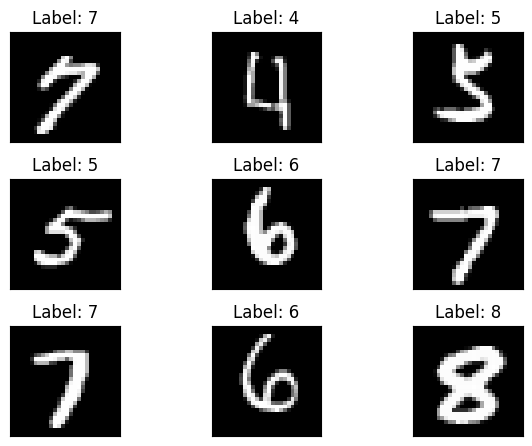

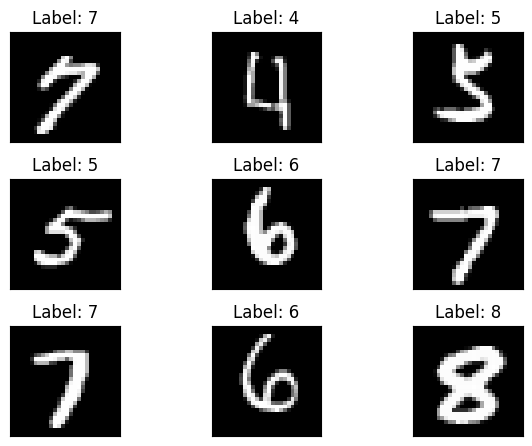

In [3]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(9):
  plt.subplot(3,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Label: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig


# **2.Define an MLP**

2.1 MLP2:MLP with 2 hidden layer

In [4]:
import torch.nn as nn
import torch.nn.functional as F
# Define the class for single layer NN
class two_layer_net(torch.nn.Module):
    # Constructor


    def __init__(self):
        super(two_layer_net, self).__init__()
        self.fc1 = nn.Linear(784, 300)
        self.fc2 = nn.Linear(300, 100)
        self.fc3 = nn.Linear(100, 10)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

m2_nn = two_layer_net()
print(m2_nn)

two_layer_net(
  (fc1): Linear(in_features=784, out_features=300, bias=True)
  (fc2): Linear(in_features=300, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=10, bias=True)
)


# **3. Define a Loss function and optimizer**
Let's use a Classification Cross-Entropy loss and SGD with momentum.

In [5]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(m2_nn.parameters(), lr=0.001, momentum=0.9)

# **4.Train the MLP**

In [6]:
for images,labels in train_loader:
  print('Initial Batch Shape:',images.size()) #batch_size_train = 100
  break
print('Batch shape after flattening:',images.view(100,-1).size())

Initial Batch Shape: torch.Size([100, 1, 28, 28])
Batch shape after flattening: torch.Size([100, 784])


In [7]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = m2_nn(inputs.view(100, -1))
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 500 == 0:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 500:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,     1] loss: 0.005
[1,   501] loss: 1.245
[2,     1] loss: 0.001
[2,   501] loss: 0.371
[3,     1] loss: 0.001
[3,   501] loss: 0.302
[4,     1] loss: 0.001
[4,   501] loss: 0.266
[5,     1] loss: 0.000
[5,   501] loss: 0.238
[6,     1] loss: 0.000
[6,   501] loss: 0.214
[7,     1] loss: 0.001
[7,   501] loss: 0.194
[8,     1] loss: 0.000
[8,   501] loss: 0.175
[9,     1] loss: 0.000
[9,   501] loss: 0.160
[10,     1] loss: 0.000
[10,   501] loss: 0.146
Finished Training


# **5.Test the MLP with testset**

In [8]:

correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = m2_nn(images.view(500, -1))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 95 %


# **6. Print out the performance using PyTorch Profiler**

In [9]:
import torch
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity

execution time analysis:

In [12]:
with profile(activities=[ProfilerActivity.CPU], record_shapes=True) as prof:
    with record_function("model_inference"):
        m2_nn(inputs.view(100, -1))

In [13]:
print(prof.key_averages(group_by_input_shape=True).table(sort_by="cpu_time_total", row_limit=10))

----------------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------------------------------------  
                  Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg    # of Calls                                 Input Shapes  
----------------------  ------------  ------------  ------------  ------------  ------------  ------------  -------------------------------------------  
       model_inference        20.04%     533.000us       100.00%       2.660ms       2.660ms             1                                           []  
          aten::linear         0.83%      22.000us        58.65%       1.560ms       1.560ms             1              [[100, 784], [300, 784], [300]]  
           aten::addmm        52.56%       1.398ms        55.79%       1.484ms       1.484ms             1      [[300], [100, 784], [784, 300], [], []]  
          aten::linear         0.38%      10.000us        11.50%     306.000

memory consumption analysis:

In [14]:
with profile(activities=[ProfilerActivity.CPU],
        profile_memory=True, record_shapes=True) as prof:
    m2_nn(inputs.view(100,-1))
print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

----------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
----------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
           aten::addmm        78.81%       1.848ms        84.26%       1.976ms     658.667us     160.16 Kb     160.16 Kb             3  
       aten::clamp_min         3.71%      87.000us         3.71%      87.000us      43.500us     156.25 Kb     156.25 Kb             2  
            aten::view         1.71%      40.000us         1.71%      40.000us      40.000us           0 b           0 b             1  
          aten::linear         1.92%      45.000us        92.32%       2.165ms     721.667us     160.16 Kb           0 b             3  
               aten::t         3.20%     

In [15]:
print(prof.key_averages().table(sort_by="cpu_memory_usage", row_limit=10))

----------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                  Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg       CPU Mem  Self CPU Mem    # of Calls  
----------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
          aten::linear         1.92%      45.000us        92.32%       2.165ms     721.667us     160.16 Kb           0 b             3  
           aten::addmm        78.81%       1.848ms        84.26%       1.976ms     658.667us     160.16 Kb     160.16 Kb             3  
            aten::relu         2.26%      53.000us         5.97%     140.000us      70.000us     156.25 Kb           0 b             2  
       aten::clamp_min         3.71%      87.000us         3.71%      87.000us      43.500us     156.25 Kb     156.25 Kb             2  
            aten::view         1.71%     